# Dogs vs Cats: Redux Kernel Edition (Transfer Learning) 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test']


In [2]:
PATH = "../input/"
TMP_PATH = "/tmp/tmp"
MODEL_PATH = "/tmp/model/"
sz=224

In [3]:
fnames = np.array([f'train/{f}' for f in sorted(os.listdir(f'{PATH}train'))])
labels = np.array([(0 if 'cat' in fname else 1) for fname in fnames])

In [4]:
print(fnames[-2],labels[-2])

train/dog.9998.jpg 1


In [5]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
arch=resnet50

**Model 1**

This model will use architecture and the trained weights of the specified "arch" . As resnet is trained on Imagnet dataset which includes cats and dogs as one of its classes, we can use it directly(Transfer Learning) with just a need of few additional finaly layers to make the architecture specific to our needs. In this model we are adding 3 new layers after "arch" and training only them and the rest of convulational layers are frozen.

In [7]:
#data loader function
data = ImageClassifierData.from_names_and_array(
    path=PATH, 
    fnames=fnames, 
    y=labels, 
    classes=['dogs', 'cats'], 
    test_name='test', 
    tfms= tfms_from_model(arch, sz)   
)

#creating a learner which is same as creating a model in keras
learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 55845584.41it/s]


100%|██████████| 196/196 [02:16<00:00,  1.43it/s]


By setting precompute=True , we are precomputing the activations of the forward passes on the training data while initializing the learner. This implements forward caching and makes training faster.

In [8]:
%%time
learn.fit(0.01, 2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.042571   0.029981   0.990506  
    1      0.027968   0.027089   0.991297                     

CPU times: user 11.8 s, sys: 6.6 s, total: 18.4 s
Wall time: 12.7 s


[0.02708925, 0.9912974683544303]

In [9]:
lrf= learn.lr_find()        #learning rate finder

A Jupyter Widget

 73%|███████▎  | 228/313 [00:04<00:01, 56.43it/s, loss=0.0444]


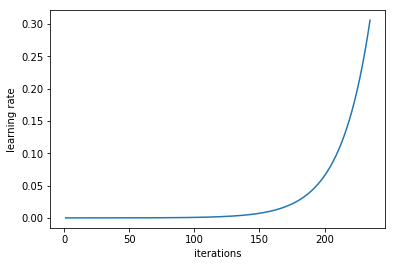

In [10]:
learn.sched.plot_lr()

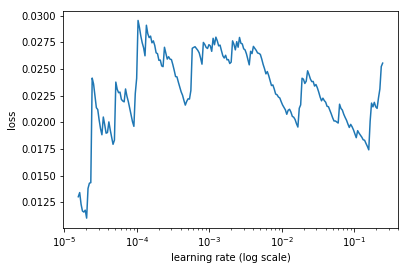

In [11]:
learn.sched.plot()

In [12]:
learn.save('model1')

This model got 0.06218 binary loss error on test set on Kaggle with resnet 34 
and 0.05806 with resnet 50 
and 0.05876 with resnet101  
and 0.06055 with TTA and resnet50

**Model 2**

In [13]:
data = ImageClassifierData.from_names_and_array(
    path=PATH, 
    fnames=fnames, 
    y=labels, 
    classes=['dogs', 'cats'], 
    test_name='test', 
    tfms= tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)   #data augmentation with side on transformation, this also resizes the image according to "sz"
)
learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)

In [14]:
learn.fit(0.01,4)     # .fit(learning_rate,cycles)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.040089   0.029252   0.990506  
    1      0.028787   0.028103   0.990506                     
    2      0.025363   0.026342   0.9911                       
    3      0.023344   0.027357   0.991495                     



[0.027357252, 0.991495253164557]

By setting precompute=True, the first step learner does is calcualte activations of training data which happens even before generating augmented data step. So we need to set precompute=False and recompute the activations as we do forward pass along with both training and augmented data once again.

In [15]:
learn.precompute=False
learn.fit(1e-2, 3, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.026944   0.024934   0.992089  
    1      0.020677   0.024885   0.992286                     
    2      0.026103   0.025234   0.991495                     
    3      0.024679   0.025387   0.991495                     
    4      0.031665   0.02371    0.992286                     
    5      0.017906   0.024163   0.992286                     



[0.024163038, 0.9922863924050633]

By setting cycle_len, we can enables stochastic gradient descent with restarts (SGDR). The basic idea is as you get closer and closer to the spot with the minimal loss, you may want to start decrease the learning rate (taking smaller steps) in order to get to exactly the right spot(learning rate annealing). Also, we are resettting the learning rate after  cycles specified by cycle_len. Restaring helps the model to get out of spiky area in descent and genralize better. 

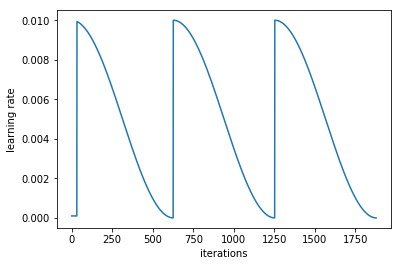

In [16]:
learn.sched.plot_lr()

In [17]:
learn.save('model2')

In [18]:
#learn.load('model2')

This model got  0.06917 log loss error on test set on Kaggle using resnet50  
and 0.05605 with TTA resent50

**Model 3**

Here we unfreeze all the layers of "arch" and recalibrate their weights.

In [19]:
learn.unfreeze()

In [20]:
lr=np.array([1e-4,1e-3,1e-2])   #differential learning rate

As the starting layers can identify basic feature like corners and gradients, there is less need to change their weights. Thus a low lr for them. The middle layers learn to recogonize specific feature like eyes, tail, ears, so morderate lr for them. The last layers learn to recogonize hunmans, objects, animals etc. , so the last layers lr needs to be high to properly tune them.

In [21]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.040272   0.026866   0.991297  
    1      0.032145   0.027405   0.992089                     
    2      0.018009   0.025891   0.991693                     
    3      0.022024   0.026703   0.9911                       
    4      0.01185    0.026303   0.989517                     
    5      0.011403   0.025554   0.991693                     
    6      0.014385   0.025076   0.992484                      



[0.025075983, 0.9924841772151899]

0.07477 log losss with resnet50 and 0.07083 with TTA and resnet 50

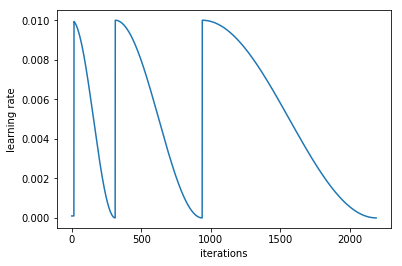

In [22]:
learn.sched.plot_lr()

In [23]:
learn.save('model3')

In [24]:
??learn.TTA

**For using Test Time Augmentation(TTA)**

In [25]:
log_predictions,y = learn.TTA(is_test=True)
prob_predictions = np.mean(np.exp(log_predictions),0)
probs = prob_predictions[:,1]

In [26]:
valid_preds= np.argmax(prob_predictions, axis=1)

**Without using TTA (run either of them)**

In [27]:
log_preds = learn.predict(is_test=True)
preds = np.argmax(log_preds, axis=1) 
probs = np.exp(log_preds[:,1])

**For creating submission file**

In [28]:
ids= fnames = np.array([f'{f}' for f in os.listdir(f'{PATH}test')])

In [29]:
ids= [i.replace(".jpg","") for i in ids]
ids[0]

'3090'

In [30]:
ans= pd.DataFrame({"id":ids,"label":probs})
ans= ans.sort_values('id')
ans.head()

,id,label
2322,1,0.999981
4892,10,0.000165
12001,100,0.000001
9899,1000,0.999994
1853,10000,0.999945


In [31]:
ans.describe()

,label
count,1.250000e+04
mean,5.004857e-01
std,4.974357e-01
min,6.177263e-11
25%,7.436891e-06
50%,5.991184e-01
75%,9.999909e-01
max,1.000000e+00


In [32]:
# model 2 mean 5.006981e-01   std  4.964828e-01    min  1.536870e-09   [0.025943222, 0.9912974683544303]

In [33]:
#model 1 mean 5.014179e-01   std 4.955358e-01     min 2.701442e-08     [0.026336912, 0.991495253164557]

In [34]:
ans.to_csv('submission.csv', index=False)

#### Transfer Learning approach using fast.ai library which makes implementing it easier. Based on 3 different approaches each with architectures- resnet34, resnet50 and resnet101... got top 5% on Kaggle leaderboard, Accuracy 99.3% and and 0.05605 binary log loss error(evaluation criteria).

#### Used Diffrential Learning Rates to tune arch , Test Time Augmentation and Learning Rate Anneling to improve model loss.